In [2]:
import os
import sys
import json
import argparse
import numpy as np
import torch
import matplotlib.pyplot as plt


from tqdm import tqdm
from torch import nn
from matplotlib.colors import LinearSegmentedColormap
from model import ClassificationModel
from dataloader import HelicoidDataModule

from torchmetrics.classification import MulticlassAccuracy, MulticlassRecall, MulticlassPrecision, MulticlassF1Score, MulticlassAUROC, MulticlassPrecisionRecallCurve

In [5]:
def get_predictions(model, dataloader):
    logits = []
    y_true = []
    for x, y in tqdm(dataloader):
        logits.append(model(x).detach().cpu())
        y_true.append(y.cpu())
    logits = torch.concatenate(logits, axis=0)
    y_true = torch.concatenate(y_true, axis=0)
    return logits, y_true

def get_metrics_logits(logits, y_true):
    accuracy = MulticlassAccuracy(num_classes=4, average=None)
    precision = MulticlassPrecision(num_classes=4, average=None)
    recall = MulticlassRecall(num_classes=4, average=None)
    f1_score = MulticlassF1Score(num_classes=4, average=None)
    roc_auc = MulticlassAUROC(num_classes=4, average=None)

    accuracy_macro = MulticlassAccuracy(num_classes=4, average="macro")
    precision_macro = MulticlassPrecision(num_classes=4, average="macro")
    recall_macro = MulticlassRecall(num_classes=4, average="macro")
    f1_score_macro = MulticlassF1Score(num_classes=4, average="macro")
    roc_auc_macro = MulticlassAUROC(num_classes=4, average="macro")

    results = {
        "accuracy": accuracy(logits, y_true).numpy().tolist(),
        "accuracy_macro": accuracy_macro(logits, y_true).numpy().tolist(),
        "precision": precision(logits, y_true).numpy().tolist(),
        "precision_macro": precision_macro(logits, y_true).numpy().tolist(),
        "recall": recall(logits, y_true).numpy().tolist(),
        "recall_macro": recall_macro(logits, y_true).numpy().tolist(),
        "f1_score": f1_score(logits, y_true).numpy().tolist(),
        "f1_score_macro": f1_score_macro(logits, y_true).numpy().tolist(),
        "roc_auc": roc_auc(logits, y_true).numpy().tolist(),
        "roc_auc_macro": roc_auc_macro(logits, y_true).numpy().tolist()
    }
    return results

def get_metrics_pred(pred, y_true):
    accuracy = MulticlassAccuracy(num_classes=4, average=None)
    precision = MulticlassPrecision(num_classes=4, average=None)
    recall = MulticlassRecall(num_classes=4, average=None)
    f1_score = MulticlassF1Score(num_classes=4, average=None)
    roc_auc = MulticlassAUROC(num_classes=4, average=None)

    accuracy_macro = MulticlassAccuracy(num_classes=4, average="macro")
    precision_macro = MulticlassPrecision(num_classes=4, average="macro")
    recall_macro = MulticlassRecall(num_classes=4, average="macro")
    f1_score_macro = MulticlassF1Score(num_classes=4, average="macro")
    roc_auc_macro = MulticlassAUROC(num_classes=4, average="macro")

    results = {
        "accuracy": accuracy(pred, y_true).numpy().tolist(),
        "accuracy_macro": accuracy_macro(pred, y_true).numpy().tolist(),
        "precision": precision(pred, y_true).numpy().tolist(),
        "precision_macro": precision_macro(pred, y_true).numpy().tolist(),
        "recall": recall(pred, y_true).numpy().tolist(),
        "recall_macro": recall_macro(pred, y_true).numpy().tolist(),
        "f1_score": f1_score(pred, y_true).numpy().tolist(),
        "f1_score_macro": f1_score_macro(pred, y_true).numpy().tolist(),
    }
    return results

def threshold_optimization(model, files, plot_roc=False):
    dm_val = HelicoidDataModule(files=files, fold="fold1")
    dm_val.setup("val")
    dataloader = dm_val.val_dataloader()

    logits, y_true = get_predictions(model, dataloader)

    roc = MulticlassPrecisionRecallCurve(num_classes=4)
    
    roc.update(logits, y_true)
    metrics = roc.compute()
    # fig_, ax_ = auc.plot(score=True)

    normal_precision, normal_recall, normal_thresholds = metrics[0][0], metrics[1][0], metrics[2][0]
    tumor_precision, tumor_recall, tumor_thresholds = metrics[0][1], metrics[1][1], metrics[2][1]
    blood_precision, blood_recall, blood_thresholds = metrics[0][2], metrics[1][2], metrics[2][2]
    background_precision, background_recall, background_thresholds = metrics[0][3], metrics[1][3], metrics[2][3]

    normal_f1_score = 2 * normal_precision * normal_recall / (normal_precision + normal_recall)
    normal_f1_score[(normal_precision < 0.01) | (normal_recall < 0.01)] = 0
    tumor_f1_score = 2 * tumor_precision * tumor_recall / (tumor_precision + tumor_recall)
    tumor_f1_score[(tumor_precision < 0.01) | (tumor_recall < 0.01)] = 0
    blood_f1_score = 2 * blood_precision * blood_recall / (blood_precision + blood_recall)
    blood_f1_score[(blood_precision < 0.01) | (blood_recall < 0.01)] = 0
    background_f1_score = 2 * background_precision * background_recall / (background_precision + background_recall)
    background_f1_score[(background_precision < 0.01) | (background_recall < 0.01)] = 0

    normal_best_idx = np.argmax(normal_f1_score)
    tumor_best_idx = np.argmax(tumor_f1_score)
    blood_best_idx = np.argmax(blood_f1_score)
    background_best_idx = np.argmax(background_f1_score)

    normal_best_threshold = normal_thresholds[normal_best_idx]
    tumor_best_threshold = tumor_thresholds[tumor_best_idx]
    blood_best_threshold = blood_thresholds[blood_best_idx]
    background_best_threshold = background_thresholds[background_best_idx]

    if plot_roc:
        plt.figure()
        plt.plot(normal_recall, normal_precision, label="Normal")
        plt.scatter(normal_recall[normal_best_idx], normal_precision[normal_best_idx], c="red")
        plt.plot(tumor_recall, tumor_precision, label="Tumor")
        plt.scatter(tumor_recall[tumor_best_idx], tumor_precision[tumor_best_idx], c="red")
        plt.plot(blood_recall, blood_precision, label="Blood")
        plt.scatter(blood_recall[blood_best_idx], blood_precision[blood_best_idx], c="red")
        plt.plot(background_recall, background_precision, label="Background")
        plt.scatter(background_recall[background_best_idx], background_precision[background_best_idx], c="red")
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.legend()

    return np.array([normal_best_threshold, tumor_best_threshold, blood_best_threshold, background_best_threshold])

loading image 004-02
loading image 008-01
loading image 008-02
loading image 022-01
loading image 022-02
loading image 039-01
loading image 039-02
loading image 041-01
loading image 041-02


100%|██████████| 94/94 [00:00<00:00, 95.80it/s] 


fold1: [0.3569163  0.7050583  0.6299292  0.22810791]
loading image 004-02
loading image 008-01
loading image 008-02
loading image 022-01
loading image 022-02
loading image 039-01
loading image 039-02
loading image 041-01
loading image 041-02


100%|██████████| 94/94 [00:00<00:00, 130.29it/s]


fold2: [0.24508579 0.5462075  0.685338   0.42396897]
loading image 004-02
loading image 008-01
loading image 008-02
loading image 022-01
loading image 022-02
loading image 039-01
loading image 039-02
loading image 041-01
loading image 041-02


100%|██████████| 94/94 [00:00<00:00, 131.54it/s]


fold3: [0.4488764  0.49824545 0.5425066  0.20567778]
loading image 004-02
loading image 008-01
loading image 008-02
loading image 022-01
loading image 022-02
loading image 039-01
loading image 039-02
loading image 041-01
loading image 041-02


100%|██████████| 94/94 [00:00<00:00, 125.81it/s]


fold4: [0.49810606 0.67007244 0.5126191  0.28098628]
loading image 004-02
loading image 008-01
loading image 008-02
loading image 022-01
loading image 022-02
loading image 039-01
loading image 039-02
loading image 041-01
loading image 041-02


100%|██████████| 94/94 [00:00<00:00, 97.99it/s] 


fold5: [0.8213273  0.28145936 0.65017444 0.13120364]


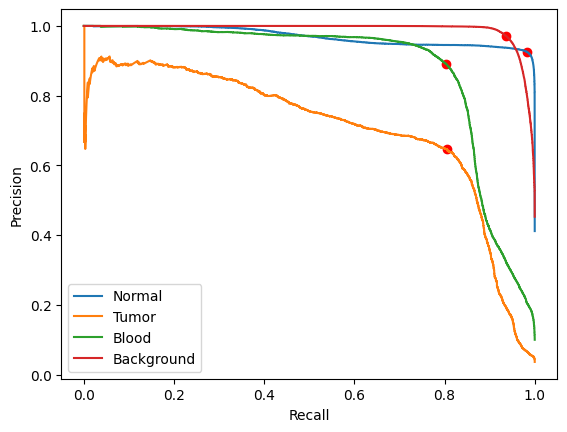

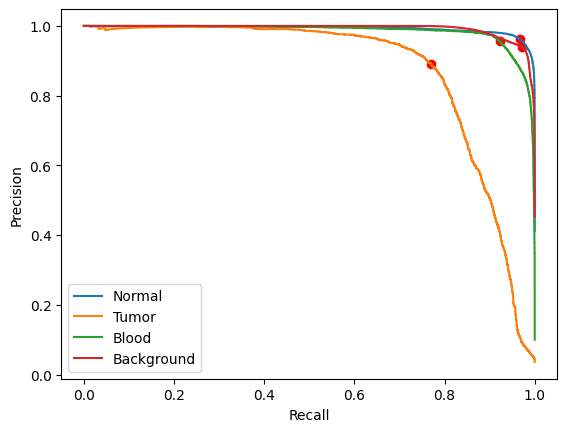

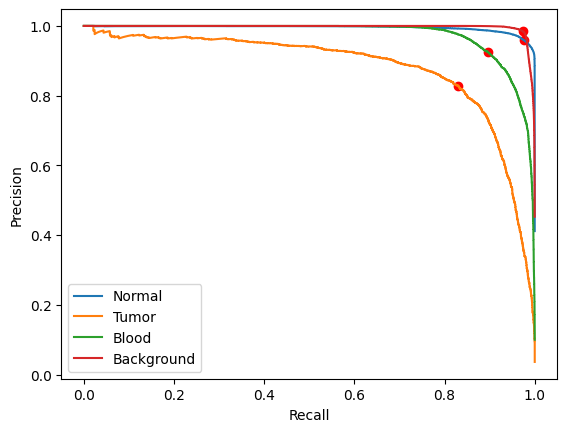

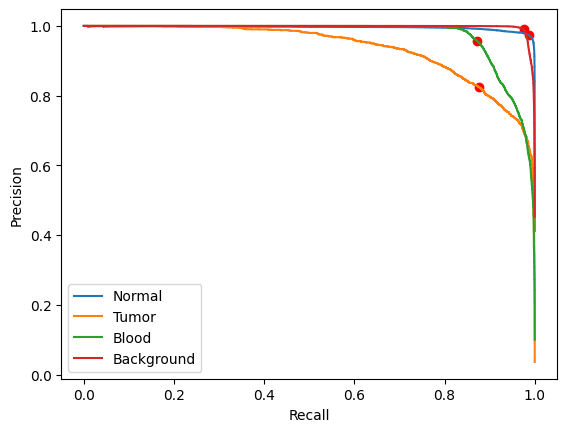

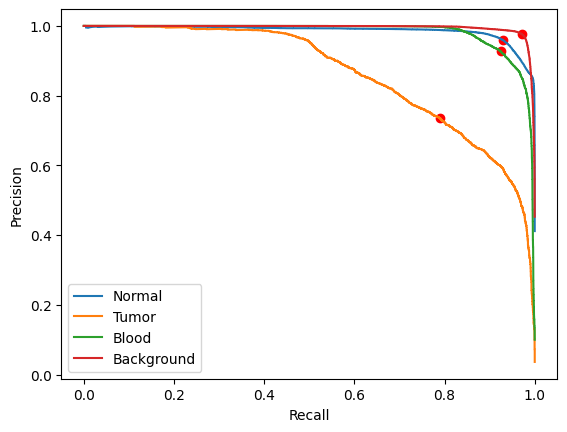

In [54]:
class Args:
    def __init__(self, mode, folds, log_dir):
        self.mode = mode
        self.folds = folds
        self.log_dir = log_dir
args = Args(mode="heatmap", folds=["fold1", "fold2", "fold3", "fold4", "fold5"], log_dir="./models/heatmaps/v3")

if args.mode == "baseline":
    files = ["preprocessed.npy"]
elif args.mode == "heatmap":
    files = ["preprocessed.npy", "heatmaps_osp.npy", "heatmaps_osp_diff.npy", "heatmaps_osp_diff_mc.npy", "heatmaps_icem.npy", "heatmaps_icem_diff.npy", "heatmaps_icem_diff_mc.npy"]
elif args.mode == "heatmap_only":
    files = ["heatmaps_osp.npy", "heatmaps_osp_diff.npy", "heatmaps_osp_diff_mc.npy", "heatmaps_icem.npy", "heatmaps_icem_diff.npy", "heatmaps_icem_diff_mc.npy"]
elif args.mode == "baseline_reduced":
    files = ["preprocessed_reduced"]

for fold in args.folds:

    checkpoint_path = os.path.join(args.log_dir, f"{fold}.ckpt")

    model = ClassificationModel.load_from_checkpoint(checkpoint_path)
    model.eval()

    thresholds = threshold_optimization(model, files)

    print(f"{fold}: {thresholds}")

In [3]:
# fold_thresholds = {
#     "fold1": [0.08391353, 0.52415013, 0.8045362,  0.57854414],
#     "fold2": [0.15574288, 0.34619144, 0.7296112,  0.717507  ],
#     "fold3": [0.30963972, 0.453404,   0.6372418,  0.33365113],
#     "fold4": [0.22257955, 0.4106498,  0.5697426,  0.57373357],
#     "fold5": [0.31754106, 0.62871784, 0.8906692,  0.5150848 ],
# }

def threshold_classification(logits, thresholds):
    probs = torch.softmax(logits, dim=1)

    # apply thresholds
    normal_mask = probs[:,0] - thresholds[0]
    tumor_mask = probs[:,1] - thresholds[1]
    blood_mask = probs[:,2] - thresholds[2]
    background_mask = probs[:,3] - thresholds[3]
    pred = torch.argmax(torch.stack([normal_mask, tumor_mask, blood_mask, background_mask], axis=1), axis=1)

    return pred

In [7]:
class Args:
    def __init__(self, mode, folds, log_dir):
        self.mode = mode
        self.folds = folds
        self.log_dir = log_dir
args = Args(mode="baseline", folds=["fold1", "fold2", "fold3", "fold4", "fold5"], log_dir="./models2/baseline/v1")

if args.mode == "baseline":
    files = ["preprocessed.npy"]
elif args.mode == "heatmap":
    files = ["preprocessed.npy", "heatmaps_osp.npy", "heatmaps_osp_diff.npy", "heatmaps_osp_diff_mc.npy", "heatmaps_icem.npy", "heatmaps_icem_diff.npy", "heatmaps_icem_diff_mc.npy"]
elif args.mode == "heatmap_only":
    files = ["heatmaps_osp.npy", "heatmaps_osp_diff.npy", "heatmaps_osp_diff_mc.npy", "heatmaps_icem.npy", "heatmaps_icem_diff.npy", "heatmaps_icem_diff_mc.npy"]
elif args.mode == "baseline_reduced":
    files = ["preprocessed_reduced"]

for fold in args.folds:

    checkpoint_path = os.path.join(args.log_dir, f"{fold}.ckpt")

    model = ClassificationModel.load_from_checkpoint(checkpoint_path)
    model.eval()

    thresholds = threshold_optimization(model, files)

    dm = HelicoidDataModule(files=files, fold=fold)
    dm.setup("test")
    dataloader = dm.test_dataloader()

    logits, y_true = get_predictions(model, dataloader)

    pred = threshold_classification(logits, thresholds)
    metrics = get_metrics_pred(pred, y_true)
    print(metrics)

    save_dir = os.path.join(args.log_dir, "results_custom_thresholds")
    os.makedirs(save_dir, exist_ok=True)
    with open(os.path.join(save_dir, f"{fold}_metrics.json"), "w") as f:
        json.dump(metrics, f)
    
    metrics = get_metrics_logits(logits, y_true)
    print(metrics)

loading image 004-02
loading image 008-01
loading image 008-02
loading image 022-01
loading image 022-02
loading image 039-01
loading image 039-02
loading image 041-01
loading image 041-02


100%|██████████| 94/94 [00:01<00:00, 82.18it/s]


loading image 010-03
loading image 016-01
loading image 016-02
loading image 016-03
loading image 016-04
loading image 016-05
loading image 021-01
loading image 021-02
loading image 021-05
loading image 037-01
loading image 037-02
loading image 037-03
loading image 042-01
loading image 042-02
loading image 042-03
loading image 054-01


100%|██████████| 203/203 [00:02<00:00, 91.98it/s] 


{'accuracy': [0.8820567727088928, 0.0039787800051271915, 0.9102969765663147, 0.7933664917945862], 'accuracy_macro': 0.6474247574806213, 'precision': [0.9482800364494324, 0.0006214396562427282, 0.758100152015686, 0.8772525787353516], 'precision_macro': 0.6460635662078857, 'recall': [0.8820567727088928, 0.0039787800051271915, 0.9102969765663147, 0.7933664917945862], 'recall_macro': 0.6474247574806213, 'f1_score': [0.913970410823822, 0.0010749798966571689, 0.8272566199302673, 0.8332034945487976], 'f1_score_macro': 0.6438763737678528}
{'accuracy': [0.8692353963851929, 0.0, 0.0, 0.9416328072547913], 'accuracy_macro': 0.4527170658111572, 'precision': [0.6990139484405518, 0.0, 0.0, 0.8342044353485107], 'precision_macro': 0.3833045959472656, 'recall': [0.8692353963851929, 0.0, 0.0, 0.9416328072547913], 'recall_macro': 0.4527170658111572, 'f1_score': [0.7748865485191345, 0.0, 0.0, 0.8846691846847534], 'f1_score_macro': 0.4148889183998108, 'roc_auc': [0.9439899921417236, 0.6073652505874634, 0.96

100%|██████████| 94/94 [00:01<00:00, 93.86it/s] 


loading image 004-02
loading image 012-01
loading image 012-02
loading image 017-01
loading image 022-02
loading image 038-01
loading image 043-01
loading image 043-02
loading image 043-04
loading image 055-01


100%|██████████| 180/180 [00:01<00:00, 93.61it/s] 


{'accuracy': [0.9832924604415894, 0.09860219061374664, 0.6247496008872986, 0.7643470764160156], 'accuracy_macro': 0.6177478432655334, 'precision': [0.8853997588157654, 0.11028169095516205, 0.8386776447296143, 0.8262407183647156], 'precision_macro': 0.665149986743927, 'recall': [0.9832924604415894, 0.09860219061374664, 0.6247496008872986, 0.7643470764160156], 'recall_macro': 0.6177478432655334, 'f1_score': [0.9317820072174072, 0.10411541908979416, 0.7160772681236267, 0.794089674949646], 'f1_score_macro': 0.6365160942077637}
{'accuracy': [0.848902702331543, 0.0, 0.7362305521965027, 0.9517050385475159], 'accuracy_macro': 0.6342095732688904, 'precision': [0.9460000395774841, 0.0, 0.8187208771705627, 0.5893016457557678], 'precision_macro': 0.5885056257247925, 'recall': [0.848902702331543, 0.0, 0.7362305521965027, 0.9517050385475159], 'recall_macro': 0.6342095732688904, 'f1_score': [0.8948250412940979, 0.0, 0.7752876281738281, 0.7278895974159241], 'f1_score_macro': 0.5995005369186401, 'roc_a

100%|██████████| 94/94 [00:01<00:00, 86.43it/s]


loading image 005-01
loading image 013-01
loading image 018-01
loading image 018-02
loading image 034-02
loading image 039-01
loading image 039-02
loading image 050-01
loading image 056-01
loading image 056-02


100%|██████████| 167/167 [00:01<00:00, 85.09it/s] 


{'accuracy': [0.9015964269638062, 0.2390901893377304, 0.8178734183311462, 0.8683923482894897], 'accuracy_macro': 0.7067381143569946, 'precision': [0.7340916991233826, 0.3026447892189026, 0.7761989235877991, 0.9424269199371338], 'precision_macro': 0.6888405680656433, 'recall': [0.9015964269638062, 0.2390901893377304, 0.8178734183311462, 0.8683923482894897], 'recall_macro': 0.7067381143569946, 'f1_score': [0.8092672824859619, 0.2671394944190979, 0.7964914441108704, 0.9038962125778198], 'f1_score_macro': 0.6941986083984375}
{'accuracy': [0.9249750971794128, 0.0, 0.8651304244995117, 0.8623377084732056], 'accuracy_macro': 0.6631108522415161, 'precision': [0.7054800391197205, 0.0, 0.592485785484314, 0.9458537697792053], 'precision_macro': 0.5609548687934875, 'recall': [0.9249750971794128, 0.0, 0.8651304244995117, 0.8623377084732056], 'recall_macro': 0.6631108522415161, 'f1_score': [0.8004531264305115, 0.0, 0.7033092379570007, 0.902167022228241], 'f1_score_macro': 0.6014823317527771, 'roc_auc

100%|██████████| 94/94 [00:00<00:00, 94.67it/s] 


loading image 007-01
loading image 019-01
loading image 035-01
loading image 040-01
loading image 040-02
loading image 051-01
loading image 057-01


100%|██████████| 106/106 [00:00<00:00, 111.58it/s]


{'accuracy': [0.9721399545669556, 0.3045576512813568, 0.0, 0.8641864657402039], 'accuracy_macro': 0.5352210402488708, 'precision': [0.8416697978973389, 0.03256693854928017, 0.0, 0.9489148855209351], 'precision_macro': 0.45578789710998535, 'recall': [0.9721399545669556, 0.3045576512813568, 0.0, 0.8641864657402039], 'recall_macro': 0.5352210402488708, 'f1_score': [0.9022124409675598, 0.05884180963039398, 0.0, 0.9045709371566772], 'f1_score_macro': 0.46640628576278687}
{'accuracy': [0.9790377020835876, 0.0, 0.0, 0.8864398002624512], 'accuracy_macro': 0.4663693904876709, 'precision': [0.5855116248130798, 0.0, 0.0, 0.9385958909988403], 'precision_macro': 0.38102686405181885, 'recall': [0.9790377020835876, 0.0, 0.0, 0.8864398002624512], 'recall_macro': 0.4663693904876709, 'f1_score': [0.7327834963798523, 0.0, 0.0, 0.911772608757019], 'f1_score_macro': 0.41113901138305664, 'roc_auc': [0.9827616214752197, 0.7200739979743958, 0.9328136444091797, 0.9536111950874329], 'roc_auc_macro': 0.897315084

100%|██████████| 94/94 [00:01<00:00, 79.74it/s] 


loading image 008-01
loading image 008-02
loading image 015-01
loading image 020-01
loading image 036-01
loading image 036-02
loading image 041-01
loading image 041-02
loading image 053-01
loading image 058-02


100%|██████████| 180/180 [00:02<00:00, 82.34it/s] 


{'accuracy': [0.9873222708702087, 0.0018237477634102106, 0.7773599624633789, 0.6703959107398987], 'accuracy_macro': 0.6092254519462585, 'precision': [0.480802446603775, 0.017337461933493614, 0.5594264268875122, 0.9690878987312317], 'precision_macro': 0.5066635608673096, 'recall': [0.9873222708702087, 0.0018237477634102106, 0.7773599624633789, 0.6703959107398987], 'recall_macro': 0.6092254519462585, 'f1_score': [0.6466848254203796, 0.0033003301359713078, 0.6506285667419434, 0.7925330996513367], 'f1_score_macro': 0.5232867002487183}
{'accuracy': [0.98674476146698, 0.0, 0.7184906601905823, 0.7217367887496948], 'accuracy_macro': 0.6067430973052979, 'precision': [0.48220670223236084, 0.0, 0.6345382928848267, 0.9451462030410767], 'precision_macro': 0.5154727697372437, 'recall': [0.98674476146698, 0.0, 0.7184906601905823, 0.7217367887496948], 'recall_macro': 0.6067430973052979, 'f1_score': [0.6478293538093567, 0.0, 0.6739099621772766, 0.8184699416160583], 'f1_score_macro': 0.5350522994995117,